# 대한민국 역대 대통령 지지율 비교

## 1. Introduction

   코로나19가 창궐하고 현 정부가 이를 잘 대응하면서 현 대통령의 지지율이 크게 증가했다고 합니다. 몇 주 뒤에는 잇다른 부동산 정책 실패로 지지율이 크게 떨어졌다고 합니다. 현 정권 지지율 둑이 구멍 뚫려 부정평가가 크게 증가한다는 뉴스도 있고, 지지층 결집하면서 콘크리트 지지율이 견고하다는 뉴스도 나옵니다. 대부분의 뉴스에는 지난 몇 주간의 지지율 변화 추이도와 역대 정권 지지도에 대한 짧막한 코멘트만 추가될 뿐, 이를 기존 지지율과 심도있게 분석하고 비교하는 기사를 찾는 것은 생각보다 쉬운 일이 아닙니다. 

만약 순수한 데이터 관점에서 현 정부의 지지도를 기존 조사와 비교한다면 어떤 결과를 얻을 수 있는지 궁금하였습니다. 정치적인 시각을 완전히 배제하고, 아래 짧은 비교를 통해 현 정부가 기존 정부 대비하여 얼마나 국민의 지지를 받고 있는지, 그리고 향후 어떤 지지율 변화를 겪을 것인지에 대한 간단한 예측을 해보려고 합니다.

## 2. Data source

대통령 지지도 조사는 13대 노태우 대통령부터 시작되었습니다. 13대(노태우 전 대통령)부터 17대(이명박 전 대통령)까지는 매 3개월마다 한국갤럽에서 조사하였고, 18대(박근혜 전 대통령)부터는 한국갤럽과 리얼미터에서 매주 조사하여 발표하고 있습니다.

한글 위키피디아 페이지에 역대 정부의 지지율 조사 결과가 잘 정리되어 있습니다 ([관련 링크](https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EC%A7%80%EC%A7%80%EC%9C%A8)).

해당 페이지를 Request를 이용하여 수집한 후 BeautifulSoup을 이용하여 Pandas DataFrame 형태로 가져오도록 합니다.

### 2.1. Import libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)  # 행열의 값이 최대로 표시되도록 설정

import requests
from bs4 import BeautifulSoup

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression  # 선형회귀 분석

### 2.2. Data request

In [2]:
# 위키피디아 - 대한민국 역대 대통령 지지율
url = 'https://ko.wikipedia.org/wiki/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD%EC%9D%98_%EB%8C%80%ED%86%B5%EB%A0%B9_%EC%A7%80%EC%A7%80%EC%9C%A8'

res = requests.get(url)
res.status_code      # 연결상태 확인. 200 ==> OK

200

In [3]:
soup = BeautifulSoup(res.text, 'lxml')  # 페이지 내에서 텍스트만 soup 객체로 반환
table = soup.find_all('table')   # soup에서 표만 table 객체로 반환

### 2.3 Prepare functions

In [4]:
# 역대 대통령 위키피디아 페이지 내 표 순서
# 문재인 2, 박근혜 9, 이명박 8, 노무현 7, 김대중 6, 김영삼 5, 노태우 4
president = {'JI_MOON': 2, 'GH_PARK': 9, 'MB_LEE': 8, 'MH_ROH': 7, 'DJ_KIM': 6, 'YS_KIM': 5, 'TW_ROH': 4}  

In [5]:
# Pandas DataFrame 생성을 위한 표 데이터 추출
def rate_extract(pcode):
    
    # 1. table에서 해당 대통령 지지율 표만 추출
    tablehtml = soup.find_all('table')[president[pcode]]
    tmp = tablehtml.find_all('tr')

    allRows = tmp[4:]  # 위의 세개 행은 삭제 (불필요 정보)
    
    # 2. HTML - table head와 table data를 분리하여 list로 보관
    headers = [[header.get_text().strip() for header in row.find_all('th')] for row in allRows]
    results = [[data.get_text().strip() for data in row.find_all('td')] for row in allRows]
    
    # 3. 미조사 열로 인해 result 내 일부 행/열에서 빈 값이 발생. 
    # rowsapn/colspan tag를 확인 후 해당 위치에 누락된 값을 포함
    colspan = []
    rowspan = []
    rowspan_max = -1

    for no, tr in enumerate(allRows):
        for td_no, data in enumerate(tr.find_all('td')):
            if data.has_attr("colspan"):
                colspan.append((no, td_no, int(data["colspan"]), data.get_text().strip()))
            elif data.has_attr("rowspan"):
                if no > rowspan_max:                    
                    rowspan.append((no, td_no, int(data["rowspan"]), data.get_text().strip()))
                    rowspan_max = no + int(data["rowspan"])
                else:
                    rowspan.append((no, td_no + 1, int(data["rowspan"]), data.get_text().strip()))
                
    if colspan:
        for i in colspan:
            # tr value of rowspan in present in 1th place in results
            results[i[0]].insert(i[1] + 1, i[3])

    if rowspan:
        for i in rowspan:
            # tr value of rowspan in present in 1th place in results
            for j in range(1, i[2]):
                #- Add value in next tr.
                results[i[0]+j].insert(i[1], i[3])
    
    df = pd.concat([pd.DataFrame(headers), pd.DataFrame(results)], axis=1)
    
    return df

In [6]:
# 위키피디아 페이지는 가독성을 위해 4개 혹은 5개 열로 정리되어 있음
# 이를 일자와 지지율의 2개의 열로 Concatenate 필요
def rate_concat(dataframe):
    dataframe.columns = ['DATE', 'RATE'] * 5
    df = pd.concat([dataframe.iloc[:, [0, 1]], \
                  dataframe.iloc[:, [2, 3]], \
                  dataframe.iloc[:, [4, 5]], \
                  dataframe.iloc[:, [6, 7]], \
                  dataframe.iloc[:, [8, 9]]], \
                 axis=0, ignore_index=True)
    return df

In [7]:
# 정렬된 DataFrame 내 Text를 Nan을 치환하여 분석을 위한 Float 값을 정리
def rate_cleaning(dataframe, name):
    dataframe.dropna(subset=['DATE'], inplace=True)
    dataframe.RATE = np.where(dataframe.RATE.str.contains('미조사'), np.nan, dataframe.RATE)
    dataframe.RATE = dataframe.RATE.str.replace('%', '').str.replace(',', '.').astype(float)
    
    dataframe.columns = ['DATE', name]
    return dataframe

### 2.4. Establish DataFrames

#### 19대 문재인 대통령

In [8]:
name = 'JI_MOON'  # 19대 대통령

df = rate_extract(name)
df.columns = ['DATE'] * 4 + ['GALO', 'REAL'] * 4  # 열 이름 할당, GALO: 한국갤럽 조사, REAL: 리얼미터 조사

In [9]:
df.head()

,DATE,DATE,DATE,DATE,GALO,REAL,GALO,REAL,GALO,REAL,GALO,REAL
0,2017년 5월 3주,2018년 5월 3주,2019년 5월 3주,2020년 5월 2주,미조사[내용 2],81.6%,76.0%,74.8%,44.0%,49.6%,65.0%,61.7%
1,2017년 5월 4주,2018년 5월 4주,2019년 5월 4주,2020년 5월 3주,미조사[내용 2],84.1%,76.0%,72.5%,46.0%,50.0%,65.0%,62.3%
2,2017년 5월 5주,2018년 5월 5주,2019년 5월 5주,2020년 5월 4주,미조사[내용 2],78.1%,75.0%,71.4%,45.0%,48.3%,65.0%,59.9%
3,2017년 6월 1주,2018년 6월 1주,2019년 6월 1주,2020년 6월 1주,84.0%,78.9%,미조사[내용 3],미조사[내용 3],46.0%,48.0%,62.0%,59.1%
4,2017년 6월 2주,2018년 6월 2주,2019년 6월 2주,2020년 6월 2주,82.0%,75.6%,79.0%,75.9%,47.0%,49.5%,60.0%,58.2%


In [10]:
df.shape

(52, 12)

반환된 DataFrame 중 각 열은 아래와 같습니다. 
* DATE : 조사시간 (매주 조사)
* GALO : 한국갤럽 조사 결과
* REAL : 리얼미터 조사 결과

한국갤럽의 경우, 매주 1000명을 대상으로 전문교육 받은 조사 인력이 개별 전화로 준비된 질문 후 답변 청취하여 지지도를 조사 합니다. 반면 리얼미터는 더 많은 대상을 ARS 기반으로 조사한다고 합니다. 

두 회사의 조사방법은 각각의 장단점이 있으나, 리얼미터의 방식이 좀 더 자동화되어 있기 때문에 데이터를 확인해보면 미조사 결과가 적고 산포도 좀 더 적은 편입니다. 다만 리얼미터는 18대 박근혜 전 대통령부터 시작된 반면, 한국갤럽은 13대 노태우 전 대통령부터 사용되었으므로 여기서는 동일한 잣대로 비교하기 위해 한국갤럽 데이터를 사용하도록 하겠습니다.

In [11]:
df.drop('REAL', axis=1, inplace=True)  # 리얼미터 조사결과 Drop. 필요 시, 'GALO'로 변경하여 확인 가능

df = pd.concat([df.iloc[:, [0, 4]], \
                  df.iloc[:, [1, 5]], \
                  df.iloc[:, [2, 6]], \
                  df.iloc[:, [3, 7]]], \
                 axis=0, ignore_index=True)

df.rename(columns={'GALO':'RATE'}, inplace=True)

df19 = rate_cleaning(df, name)

In [12]:
df19.head(10)

,DATE,JI_MOON
0,2017년 5월 3주,NaN
1,2017년 5월 4주,NaN
2,2017년 5월 5주,NaN
3,2017년 6월 1주,84.0
4,2017년 6월 2주,82.0
5,2017년 6월 3주,83.0
6,2017년 6월 4주,79.0
7,2017년 7월 1주,83.0
8,2017년 7월 2주,80.0
9,2017년 7월 3주,74.0


<AxesSubplot:>

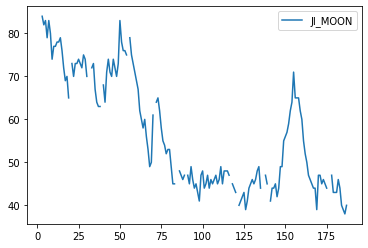

In [13]:
df19.plot()

#### 18대 박근혜 대통령

In [14]:
name = 'GH_PARK'

df = rate_extract(name)
df.columns = ['DATE', 'GALO', 'REAL'] * 4
df.drop('REAL', axis=1, inplace=True)

df = pd.concat([df.iloc[:, [0, 1]], \
                  df.iloc[:, [2, 3]], \
                  df.iloc[:, [4, 5]], \
                  df.iloc[:, [6, 7]]], \
                 axis=0, ignore_index=True)
df.rename(columns={'GALO':'RATE'}, inplace=True)

df18 = rate_cleaning(df, name)

In [15]:
df18.tail()

,DATE,GH_PARK
193,2016년 11월 3주,5.0
194,2016년 11월 4주,4.0
195,2016년 11월 5주,NaN
196,2016년 12월 1주,4.0
197,2016년 12월 2주,5.0


#### 17~13대 대통령 DataFrame 생성

In [16]:
name = 'MB_LEE'  # 17대 대통령

df = rate_extract(name)
df = rate_concat(df)
df17 = rate_cleaning(df, name)

In [17]:
name = 'MH_ROH'  # 16대 대통령

df = rate_extract(name)
df = rate_concat(df)
df16 = rate_cleaning(df, name)

In [18]:
name = 'DJ_KIM'  # 15대 대통령

df = rate_extract(name)
df = rate_concat(df)
df15 = rate_cleaning(df, name)

In [19]:
name = 'YS_KIM'  # 14대 대통령

df = rate_extract(name)
df = rate_concat(df)
df14 = rate_cleaning(df, name)

In [20]:
name = 'TW_ROH'  # 13대 대통령

df = rate_extract(name)
df = rate_concat(df)
df = df.iloc[:18, :]  # 위키페이지 내 HTML 에러 존재. 해당 에러 제거
df13 = rate_cleaning(df, name)

In [21]:
df18.head()  # 18대 대통령 결과 --> 매주 조사

,DATE,GH_PARK
0,2013년 2월 4주,NaN
1,2013년 3월 1주,NaN
2,2013년 3월 2주,NaN
3,2013년 3월 3주,44.0
4,2013년 3월 4주,41.0


In [22]:
df17.head()  # 17대 대통령 결과 --> 매 분기 조사

,DATE,MB_LEE
0,2008년 3월 ~ 5월,52.0
1,2008년 6월 ~ 8월,21.0
2,2008년 9월 ~ 11월,24.0
3,2008년 12월 ~ 2009년 2월,32.0
4,2009년 3월 ~ 5월,34.0


## 3. Methodology

13대부터 19대 대통령까지 DataFrame을 위키피디아로부터 추출해 내었으므로 결과물에 대해 확인해 보도록 합시다.

In [23]:
# 18, 19대 대통령 지지율 비교
apprate_week = pd.concat([df19, df18], axis=1)
apprate_week.index.name = 'WEEK'
apprate_week.drop('DATE', axis=1, inplace=True)

문재인 대통령의 경우, null data가 크게 나오는 이유는 아직 퇴임하지 않아 데이터가 계속 추가될 예정이기 때문입니다.

이외의 null data 값은 모두 미조사에 의한 것입니다. 한국갤럽 조사는 조사원에 의존하기 때문에 명절 등 연휴가 있거나 선거로 인한 여론조사 결과 발표가 제한될 경우, 조사를 하지않습니다. 리얼미터 데이터를 사용하면 null 값이 훨씬 줄어들게 됩니다 (조사 방법 차이). 현재 Index값이 Week order를 반영하는 유의미한 값이고, 해당 데이터가 groupby를 이용해 분기별 데이터로 치환될 예정이므로 별도 dropna 없이 유지하도록 합시다.

In [24]:
apprate_week.isna().sum()

JI_MOON    29
GH_PARK    16
dtype: int64

In [25]:
apprate_week.tail(10)

,JI_MOON,GH_PARK
WEEK,,
188,NaN,26.0
189,NaN,25.0
190,NaN,17.0
191,NaN,5.0
192,NaN,5.0
193,NaN,5.0
194,NaN,4.0
195,NaN,NaN
196,NaN,4.0


<AxesSubplot:xlabel='WEEK'>

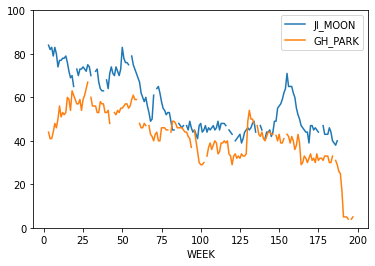

In [26]:
apprate_week.plot(ylim=(0, 100))

17대 이전에는 매 분기, 즉 3개월마다 지지도 조사를 했기 때문에 이후 결과를 같이 비교하기 위해서는 상기 데이터를 분기데이터로 변경해야 합니다.

In [27]:
apprate_week['QT'] = apprate_week.index//13
apprate_groupby_qt = apprate_week.groupby('QT').mean()  # Groupby로 분기별 평균 데이터 반환

In [28]:
apprate_groupby_qt.isna().sum()

JI_MOON    1
GH_PARK    0
dtype: int64

In [29]:
apprate_groupby_qt.tail()

,JI_MOON,GH_PARK
QT,,
11,53.615385,41.954545
12,53.846154,36.384615
13,44.454545,32.153846
14,41.166667,20.000000
15,NaN,4.500000


18/19대 대통령 분기별 평균 지지도를 13~17대 대통령 지지도와 병합합니다.

In [75]:
apprate = pd.concat([apprate_groupby_qt, df17, df16, df15, df14, df13], axis=1)
apprate.drop('DATE', axis=1, inplace=True)
apprate = apprate.round(1)
apprate.index.name = 'QUARTER'

In [76]:
apprate.isna().sum()

JI_MOON    5
GH_PARK    4
MB_LEE     0
MH_ROH     0
DJ_KIM     0
YS_KIM     0
TW_ROH     6
dtype: int64

In [77]:
apprate.tail()

,JI_MOON,GH_PARK,MB_LEE,MH_ROH,DJ_KIM,YS_KIM,TW_ROH
QUARTER,,,,,,,
15,NaN,4.5,32.0,12.0,31.0,28.0,15.0
16,NaN,NaN,24.0,16.0,33.0,14.0,NaN
17,NaN,NaN,25.0,24.0,26.0,7.0,12.0
18,NaN,NaN,23.0,27.0,28.0,8.0,NaN
19,NaN,NaN,23.0,27.0,24.0,6.0,NaN


## 4. Result

#### 4.1 Count and missing values

대한민국 대통령 임기는 13대 노태우 정부부터 5년 단임으로 변경 후 유지 중이므로, 매 분기 데이터 확인 시 총 20개 데이터가 확보 됩니다.

아직 임기 중인 문재인 대통령과 임기를 채우지 못한 박근혜 대통령을 제외하면 이명박 대통령부터 김영삼 대통령까지 모두 20개 데이터가 확인됩니다. 노태우 정부 때는 미조사 결과가 많은데 별도 코멘트가 위키피디아에 남아있지 않습니다. 아마 조사 초기라 정착되기까지 어려움이 있거나, 아직 군사정부 시대라 일부 제한이 있지 않았을까 추측해 봅니다.

In [33]:
apprate.describe()

,JI_MOON,GH_PARK,MB_LEE,MH_ROH,DJ_KIM,YS_KIM,TW_ROH
count,15.000000,16.000000,20.000000,20.000000,20.000000,20.000000,14.000000
mean,56.213333,40.543750,35.150000,27.350000,42.850000,39.550000,29.785714
std,13.098357,14.025452,10.074851,10.209773,15.023753,22.899035,14.342935
min,41.200000,4.500000,21.000000,12.000000,24.000000,6.000000,12.000000
25%,45.500000,35.650000,24.750000,22.750000,28.750000,28.000000,19.750000
50%,53.600000,42.850000,35.000000,27.000000,42.000000,36.500000,28.000000
75%,69.850000,48.875000,44.000000,30.000000,54.500000,55.000000,38.000000
max,79.700000,58.200000,52.000000,60.000000,71.000000,83.000000,57.000000


#### 4.2 Mean

지지도 평균으로 볼 때, 현 정부의 지지도는 상당히 높은 편입니다. 하지만 아직 집권이 끝나지 않아 집권 말기의 낮은 지지도가 취합되지 않음을 고려해야 합니다.

평균 데이터 기준으로 김대중 정부, 박근혜 정부, 김영삼 정부 순으로 정권 지지도가 높았습니다. 반면 노무현 정부, 노태우 정부 순으로 정권 지지도가 낮았음을 확인할 수 있습니다.

In [34]:
apprate.mean().sort_values(ascending=False)

JI_MOON    56.213333
DJ_KIM     42.850000
GH_PARK    40.543750
YS_KIM     39.550000
MB_LEE     35.150000
TW_ROH     29.785714
MH_ROH     27.350000
dtype: float64

YEAR
1     YS_KIM: 74.0
2    JI_MOON: 55.3
3    JI_MOON: 47.0
4    JI_MOON: 46.5
5     DJ_KIM: 27.8
dtype: object

In [120]:
apprate['YEAR'] = apprate.index // 4 + 1
apprate_year = apprate.groupby(by=['YEAR']).mean()

apprate_year['MAX'] = apprate_year.idxmax(axis=1) + ': ' + apprate_year.max(axis=1).map('{:,.1f}'.format).astype('str')

apprate_year

,JI_MOON,GH_PARK,MB_LEE,MH_ROH,DJ_KIM,YS_KIM,TW_ROH,MAX
YEAR,,,,,,,,
1,73.575,54.100,32.25,37.75,63.00,74.00,45.00,YS_KIM: 74.0
2,55.325,45.125,36.00,27.25,52.00,47.50,33.00,JI_MOON: 55.3
3,47.025,39.675,46.00,29.50,42.75,31.50,24.75,JI_MOON: 47.0
4,46.500,23.275,37.75,18.75,28.75,36.00,13.50,JI_MOON: 46.5
5,NaN,NaN,23.75,23.50,27.75,8.75,12.00,DJ_KIM: 27.8


In [88]:
apprate.drop('YEAR', axis=1, inplace=True)

#### 4.3 Standard deviation & Range

지지도 산포 측면에서 김영삼 정부가 가장 큰 변화가 있었습니다.   
이명박 정부 대비하면 표준 편차 및 최대-최소 차이가 2배 이상의 산포를 보입니다. 문민정부 출범 당시 상당한 기대와 지지를 받았습니다만, 정권 말기 IMF로 인한 지지율 감소가 원인이 아닐까 추측해 봅니다.

In [35]:
apprate.std().sort_values(ascending=False)

YS_KIM     22.899035
DJ_KIM     15.023753
TW_ROH     14.342935
GH_PARK    14.025452
JI_MOON    13.098357
MH_ROH     10.209773
MB_LEE     10.074851
dtype: float64

In [36]:
(apprate.max()-apprate.min()).sort_values(ascending=False)

YS_KIM     77.0
GH_PARK    53.7
MH_ROH     48.0
DJ_KIM     47.0
TW_ROH     45.0
JI_MOON    38.5
MB_LEE     31.0
dtype: float64

#### 4.4 Max & min

역대 가장 높은 지지율은 김영삼 정부 때입니다. 무려 83%나 되네요. 모두 집권 후 초반 지지율입니다. 당시 문민정부에 대한 기대가 얼마나 높았는지 간접적으로 알 수 있습니다.

반면 이명박 정부 지지율은 가장 높을 때도 50%를 간신히 넘었습니다.

In [37]:
apprate.max().sort_values(ascending=False)

YS_KIM     83.0
JI_MOON    79.7
DJ_KIM     71.0
MH_ROH     60.0
GH_PARK    58.2
TW_ROH     57.0
MB_LEE     52.0
dtype: float64

In [38]:
df14[df14.YS_KIM == df14.YS_KIM.max()]  # 14대 대통령 최대 지지율 시기

,DATE,YS_KIM
1,1993년 6월 ~ 8월,83.0
2,1993년 9월 ~ 11월,83.0


In [39]:
df17[df17.MB_LEE == df17.MB_LEE.max()]  # 17대 대통령 최대 지지율 시기

,DATE,MB_LEE
0,2008년 3월 ~ 5월,52.0


역대 가장 낮은 지지율은 박근혜 정부와 김영삼 정부 때입니다. 각각 탄핵과 IMF라는 국가 위기로 인해 대통령 지지도가 크게 하락하고 국정운영에 무리가 있던 시기였습니다. 모두 정권 말기 때 모습입니다 (18대 DataFrame은 Weekly로 작성되었기 때문에 Quarter data와 일부 차이가 있습니다).



In [40]:
apprate.min().sort_values()

GH_PARK     4.5
YS_KIM      6.0
MH_ROH     12.0
TW_ROH     12.0
MB_LEE     21.0
DJ_KIM     24.0
JI_MOON    41.2
dtype: float64

In [42]:
df14[df14.YS_KIM == df14.YS_KIM.min()]   # 14대 대통령 최소 지지율 시기

,DATE,YS_KIM
19,1997년 12월 ~ 1998년 2월,6.0


In [41]:
df18.tail(10)  # 18대 대통령 최소 지지율 시기

,DATE,GH_PARK
188,2016년 10월 2주,26.0
189,2016년 10월 3주,25.0
190,2016년 10월 4주,17.0
191,2016년 11월 1주,5.0
192,2016년 11월 2주,5.0
193,2016년 11월 3주,5.0
194,2016년 11월 4주,4.0
195,2016년 11월 5주,NaN
196,2016년 12월 1주,4.0
197,2016년 12월 2주,5.0


#### 4.5 Trend

분기별 대통령 지지도 변화는 아래와 같습니다. 대통령 지지도 변화는 모든 정권에서 집권 초기에는 높은 지지도로 출발하다 점차 지지율 하락을 겪는 모습을 보입니다.

전반적으로 19대 현 정부의 지지율은 타 정부와 비교할 때 가장 높은 수준에서 계속 유지되고 있는 것으로 보입니다.

In [43]:
plt.style.use('fivethirtyeight')  # Fivethirtyeight 그래프 스타일 적용

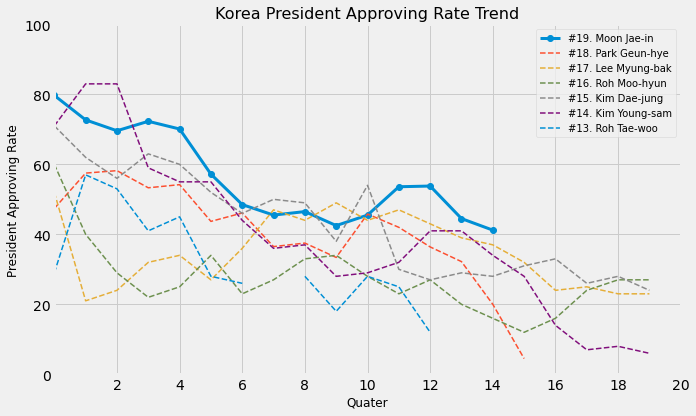

In [44]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

president_labels = ['#19. Moon Jae-in', '#18. Park Geun-hye', '#17. Lee Myung-bak', '#16. Roh Moo-hyun',\
                    '#15. Kim Dae-jung', '#14. Kim Young-sam', '#13. Roh Tae-woo']

ax.plot(apprate.index, apprate.loc[:, 'JI_MOON'], marker='o', ls='-', linewidth=3)
ax.plot(apprate.index, apprate.loc[:, 'GH_PARK':'TW_ROH'], ls='--', linewidth=1.5)

ax.set_ylim(0, 100)
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(2, 22, step=2))

plt.legend((president_labels), fontsize=10)

plt.title('Korea President Approving Rate Trend', fontsize=16)
plt.xlabel('Quater', fontsize=12)
plt.ylabel('President Approving Rate', fontsize=12)

plt.show()

현 정부와 이전 정부들을 비교해 보도록 합시다. 18대부터 13대 정부까지의 열을 바탕으로 평균, 최대, 최소값 열을 생성합니다.

In [45]:
start = 'GH_PARK' 
end = 'TW_ROH'
apprate['MEAN'] = apprate.loc[:, start:end].mean(axis=1)
apprate['MAX'] = apprate.loc[:, start:end].max(axis=1)
apprate['MIN'] = apprate.loc[:, start:end].min(axis=1)

<AxesSubplot:xlabel='QUARTER'>

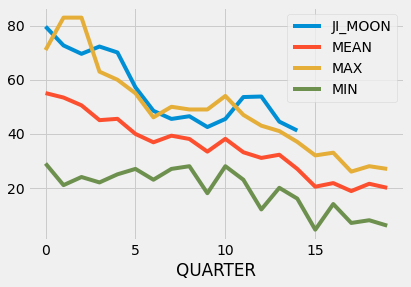

In [46]:
apprate[['JI_MOON', 'MEAN', 'MAX', 'MIN']].plot()

#### 4.6 Linear Regression

선형 분석을 위한 별도의 DataFrame을 생성합니다. X, Y값을 용이하게 지정하기 위해 Index를 Reset하여 별도의 열로 원복합니다.

In [47]:
app = apprate.reset_index()

In [48]:
app.head()

,QUARTER,JI_MOON,GH_PARK,MB_LEE,MH_ROH,DJ_KIM,YS_KIM,TW_ROH,MEAN,MAX,MIN
0,0,79.7,47.4,52.0,60.0,71.0,71.0,29.0,55.066667,71.0,29.0
1,1,72.7,57.5,21.0,40.0,62.0,83.0,57.0,53.416667,83.0,21.0
2,2,69.6,58.2,24.0,29.0,56.0,83.0,53.0,50.533333,83.0,24.0
3,3,72.3,53.3,32.0,22.0,63.0,59.0,41.0,45.050000,63.0,22.0
4,4,70.1,54.2,34.0,25.0,60.0,55.0,45.0,45.533333,60.0,25.0


앞의 그래프에서 본 것처럼 대통령 지지도는 정권 초기에는 높게 형성되었다, 임기에 따라 점차 감소하므로 음의 상관관계를 갖는 선형 모델임을 예측할 수 있습니다. 상관계수 및 선형관계를 확인 해 봅니다.

In [49]:
app.corr().QUARTER.sort_values()

MEAN      -0.972852
MAX       -0.936115
DJ_KIM    -0.924055
YS_KIM    -0.919006
JI_MOON   -0.850764
GH_PARK   -0.839193
TW_ROH    -0.810237
MIN       -0.799131
MH_ROH    -0.593830
MB_LEE    -0.235327
QUARTER    1.000000
Name: QUARTER, dtype: float64

In [50]:
mpl.rcParams.update(mpl.rcParamsDefault)  # Pyplot style 해제

<AxesSubplot:xlabel='QUARTER', ylabel='MEAN'>

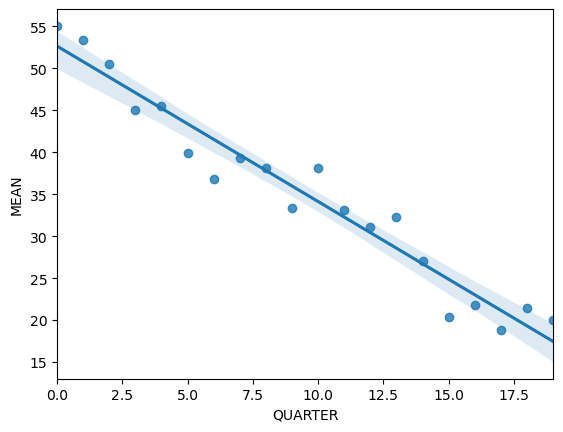

In [51]:
sns.regplot(x='QUARTER', y='MEAN', data=app)

<AxesSubplot:xlabel='QUARTER', ylabel='MAX'>

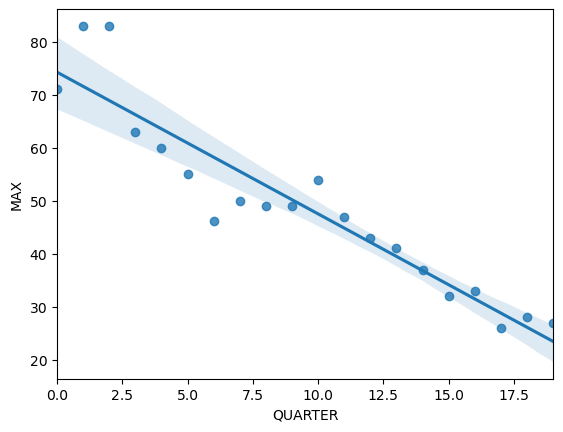

In [52]:
sns.regplot(x='QUARTER', y='MAX', data=app)

<AxesSubplot:xlabel='QUARTER', ylabel='MIN'>

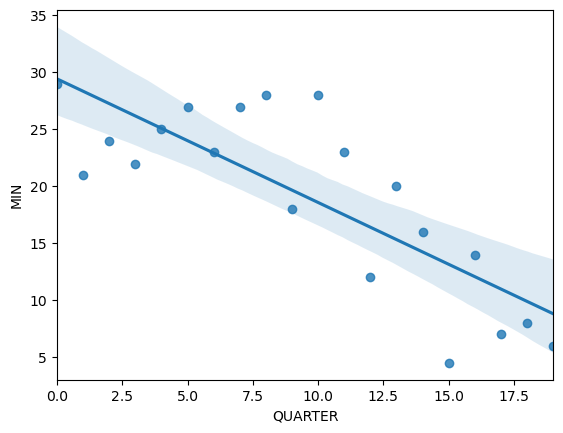

In [53]:
sns.regplot(x='QUARTER', y='MIN', data=app)

<AxesSubplot:xlabel='QUARTER', ylabel='JI_MOON'>

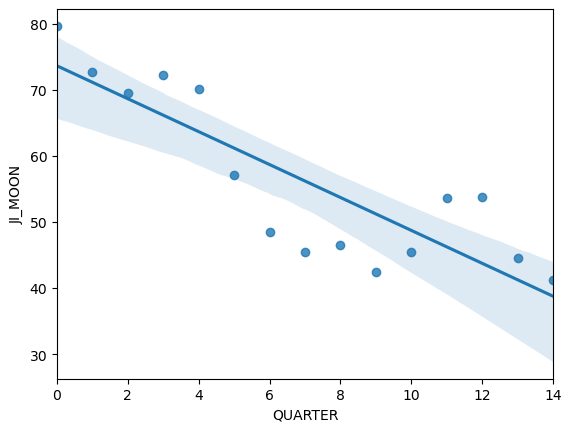

In [54]:
sns.regplot(x='QUARTER', y='JI_MOON', data=app)

정권마다 정치적 이슈로 지지도 등락이 있습니다만, 대부분 음의 상관관계를 보이고 있습니다. 특히 기존 지지도 매 분기 평균과 최대값의 경우, 0.9 이상의 높은 음의 상관관계를 보이고 있으며 선형모델이 잘 적용되는 것을 확인할 수 있습니다.

Scikit learn 라이브러리를 활용하여 선형모델을 생성하고 이를 통해 현 정권 지지도와 비교하고, 향후 지지도 하락을 예측해 보도록 합시다.

In [55]:
lm = LinearRegression()  # Linear model 생성

In [56]:
X = app[['QUARTER']]
Y = app.MEAN

lm.fit(X, Y)
lm.score(X, Y)

0.9464400478410796

R-sqaured 값이 0.94로 일부 Noise를 제거하면 거의 선형모델에 일치하고 있음을 보입니다 (정권마다 차이가 있습니다만, 대부분 정권이 상당한 노력에도 불구하고 우리나라 정치 환경 및 국민정서에서는 결국 선형적으로 지지율 하락이 필연적으로 해석할 수도 있겠습니다). 생성된 모델로 예측한 값을 별도 Array로 보관합시다.

동일한 작업을 MAX와 JI_MOON열에 대해서도 반복합니다.

In [57]:
predict_mean = lm.predict(X)
predict_mean

array([52.66309524, 50.81043609, 48.95777694, 47.10511779, 45.25245865,
       43.3997995 , 41.54714035, 39.6944812 , 37.84182206, 35.98916291,
       34.13650376, 32.28384461, 30.43118546, 28.57852632, 26.72586717,
       24.87320802, 23.02054887, 21.16788972, 19.31523058, 17.46257143])

In [121]:
Y = app.MAX

lm.fit(X, Y)
predict_max = lm.predict(X)
lm.score(X, Y)

0.8763105114549208

In [122]:
Y = app.JI_MOON

lm.fit(X[:15], Y[:15])  # 문재인 대통령의 경우, 아직 재임 중이므로 지지도가 15분기까지만 있음
predict_moon = lm.predict(X)
lm.score(X[:15], Y[:15])

0.7237986057048711

In [60]:
lm.intercept_

73.65583333333333

In [61]:
lm.coef_

array([-2.49178571])

In [62]:
float(lm.coef_) * 14.5 + lm.intercept_

37.52494047619048

In [63]:
apprate['PRE_MEAN'] = predict_mean
apprate['PRE_MAX'] = predict_max
apprate['PRE_MOON'] = predict_moon

apprate.head()

,JI_MOON,GH_PARK,MB_LEE,MH_ROH,DJ_KIM,YS_KIM,TW_ROH,MEAN,MAX,MIN,PRE_MEAN,PRE_MAX,PRE_MOON
QUARTER,,,,,,,,,,,,,
0,79.7,47.4,52.0,60.0,71.0,71.0,29.0,55.066667,71.0,29.0,52.663095,74.267143,73.655833
1,72.7,57.5,21.0,40.0,62.0,83.0,57.0,53.416667,83.0,21.0,50.810436,71.592180,71.164048
2,69.6,58.2,24.0,29.0,56.0,83.0,53.0,50.533333,83.0,24.0,48.957777,68.917218,68.672262
3,72.3,53.3,32.0,22.0,63.0,59.0,41.0,45.050000,63.0,22.0,47.105118,66.242256,66.180476
4,70.1,54.2,34.0,25.0,60.0,55.0,45.0,45.533333,60.0,25.0,45.252459,63.567293,63.688690


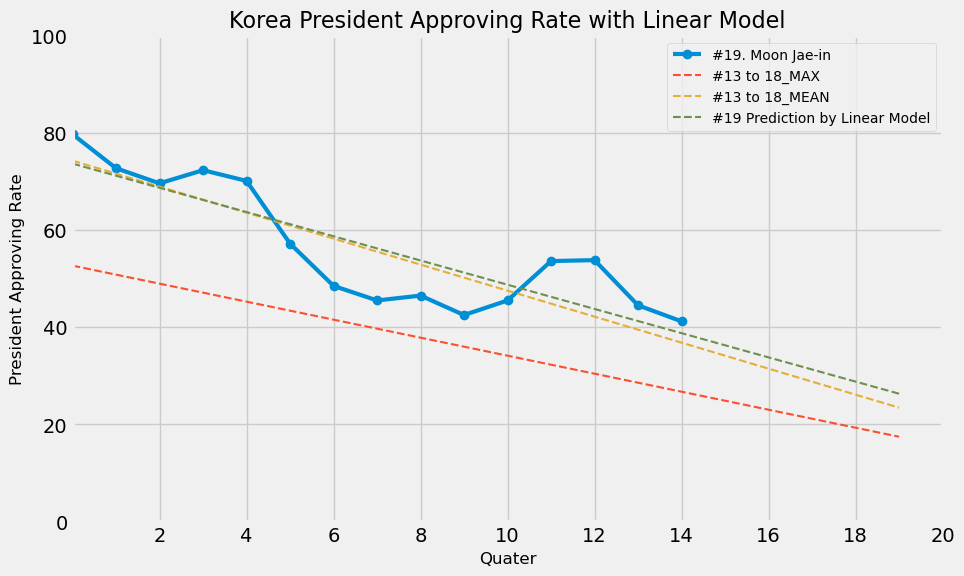

In [64]:
plt.style.use('fivethirtyeight')  # Fivethirtyeight 그래프 스타일 적용

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

labels = ['#19. Moon Jae-in', '#13 to 18_MAX', '#13 to 18_MEAN', '#19 Prediction by Linear Model']

ax.plot(apprate.index, apprate.loc[:, 'JI_MOON'], marker='o', ls='-', linewidth=3)
ax.plot(apprate.index, apprate.loc[:, 'PRE_MEAN':'PRE_MOON'], ls='--', linewidth=1.5)

ax.set_ylim(0, 100)
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(2, 22, step=2))

plt.legend((labels), fontsize=10)

plt.title('Korea President Approving Rate with Linear Model', fontsize=16)
plt.xlabel('Quater', fontsize=12)
plt.ylabel('President Approving Rate', fontsize=12)

plt.show()

## 5. Discussion

현 19대 정부의 지지도(#19. Moon Jae-in)는 기존 13대부터 18대 정부 지지도 평균을 상회하며 유지되고 있고, 선형 회귀선이 기존 정부들의 분기별 최대값과 거의 유사하게 거동하고 있는 것을 볼 때 가장 인기있는 정부라고 말할 수 있을 것 같습니다. 

최근 각종 매체에서 현 정부 지지율이 역대 최저로 떨어졌다는 뉴스가 자극적으로 나오고 있습니다만, 기존 정부을 이력을 확인할 때 모든 정부에서 임기가 진행됨에 따라 지지도 하락은 필연적으로 발생하였고 그 평균값을 선형 모델에 굉장히 잘 일치합니다.
    
12월 초 진행된 대통령 지지도 조사에서 40%의 콘크리트 지지율이 무너졌다며 모든 매체에서 대서특필하고 있습니다([관련 기사 링크](https://www.donga.com/news/Politics/article/all/20201205/104297349/1)). 해당 지지율은 39%입니다. 반면 위의 선형모델로 예측된 14.5분기 19대 정부 지지도는 37.5%입니다. 즉 현 정부 지지도는 임기 초부터 하락한 기존 결과값과 아직 유사하게 거동하고 있는 것으로 보입니다.

In [65]:
float(lm.coef_) * 14.5 + lm.intercept_   # Linear model, 14.5분기 적용 시

37.52494047619048

따라서 현 정부 지지율이 집권 이후 최저라는 뉴스는 당연한 사실이 자극적으로 포장되었을 가능성을 내포하고 있으며, 이보다는 아래의 지표로 현 정부 지지율을 판단하는 것이 합리적으로 보입니다.

1. 선형 모델 대비한 현 정부 지지도 비교
    * '#19 Prediction by Linear Model'은 현재까지 19대 정부의 지지도를 바탕으로 생성된 선형 모델입니다. 만약 남은 임기에서 조사되는 지지도가 해당 모델보다 빠르게 하락한다면, 현 정부 지지도가 정권 초기 대비하여 하락폭이 크다라고 말할 수 있을 것입니다.
2. 기존 정부 평균에 대비한 현 정부 지지도 비교
    * 앞서 지적한 것처럼 19대 정부에 대한 여러 논란에도 불구하고, 현 정부의 인기도는 기존 정부 대비하여 상당히 높은 편입니다. 현재까지는 기존 지지도 최대값과 거의 유사한 수준에서 거동 중이나 만약 남은 임기에서 지지도 하락이 평균선에 근접하거나 이보다 하락한다면 현 정부 지지도가 크게 하락하여 정국 운영에 상당한 어려움이 될 것을 예상할 수 있습니다.

## 6. Conclusion

대통령 지지도 조사는 현 정부 및 정권에 대한 국민 여론의 바로미터이기 때문에 많은 정치 평론가들이 나름의 정치적 분석을 내놓고 이를 가지고 설왕설래하는 뜨거운 주제입니다. 반면 국민 정서로 통용되는 다른 정성적인 근거에 비해 매주 수치로 조사되는 잘 정리된 데이터 집합이기도 합니다.

본 분석에서는 한국갤럽 조사 결과를 바탕으로 13대부터 19대 현 정부까지의 대통령 지지도를 정치적 시각을 배제한 데이터 관점에서 분석을 수행하였습니다. 그리고 이를 통해 대통령 지지도는 임기에 따른 선형모델로 상당히 높은 정확도로 설명 가능하며, 지지도 하락이 필연적임을 확인하였습니다.

상기에서 적용된 모델이 1차 선형회귀로 가장 단순한 모델임에도 불구하고 대부분의 언론 및 매체에서 해당 내용에 대한 간단한 이해도 없이 현재값을 수 주, 혹은 수 개월 전의 값과 비교하며 여러가지 문제를 제기하는 것은 그다지 합리적으로 보이지 않습니다. 정치적인 해법도 중요하지만 때로는 데이터에 기반한 논평이 진행되어야 해당 여론 조사가 좀더 목저게 부합한 형태로 사용되는 것이 아닐까하는 생각을 합니다.